In [1]:
import sys
sys.path.append(r'pytorch-cifar')
sys.path.append(r'pytorch-cifar\models')

In [2]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import *
from models.custom_resnet import Custom_ResNet18
from utils import progress_bar

In [3]:
# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 Training')
# parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
# parser.add_argument('--resume', '-r', action='store_true',
#                     help='resume from checkpoint')
# args = parser.parse_args()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

cuda


In [7]:
import torchvision.transforms as transforms

In [8]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Model
print('==> Building model..')
net = ResNet18()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

==> Building model..


In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        # print(correct,'/',total)

      
    print('Train Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    train_losses.append(loss) 
    train_acc.append(100.*correct/total)


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                        % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total

    test_losses.append(loss) 
    test_acc.append(100.*correct/total)

    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    


In [11]:
for epoch in range(start_epoch, start_epoch+20):
    train(epoch)
    test(epoch)
    scheduler.step()



Epoch: 0
Train Loss: 1.596 | Train Acc: 41.630% (20815/50000)
Test Loss: 1.136 | Test Acc: 58.590% (5859/10000)
Saving..

Epoch: 1
Train Loss: 1.049 | Train Acc: 62.720% (31360/50000)
Test Loss: 0.843 | Test Acc: 69.860% (6986/10000)
Saving..

Epoch: 2
Train Loss: 0.805 | Train Acc: 72.024% (36012/50000)
Test Loss: 0.735 | Test Acc: 75.640% (7564/10000)
Saving..

Epoch: 3
Train Loss: 0.689 | Train Acc: 76.308% (38154/50000)
Test Loss: 0.700 | Test Acc: 75.580% (7558/10000)

Epoch: 4
Train Loss: 0.610 | Train Acc: 79.118% (39559/50000)
Test Loss: 0.600 | Test Acc: 79.400% (7940/10000)
Saving..

Epoch: 5
Train Loss: 0.559 | Train Acc: 80.642% (40321/50000)
Test Loss: 0.505 | Test Acc: 82.690% (8269/10000)
Saving..

Epoch: 6
Train Loss: 0.521 | Train Acc: 82.168% (41084/50000)
Test Loss: 0.472 | Test Acc: 84.050% (8405/10000)
Saving..

Epoch: 7
Train Loss: 0.492 | Train Acc: 83.244% (41622/50000)
Test Loss: 0.486 | Test Acc: 83.550% (8355/10000)

Epoch: 8
Train Loss: 0.471 | Train Acc: 8

Text(0.5, 1.0, 'Test Accuracy')

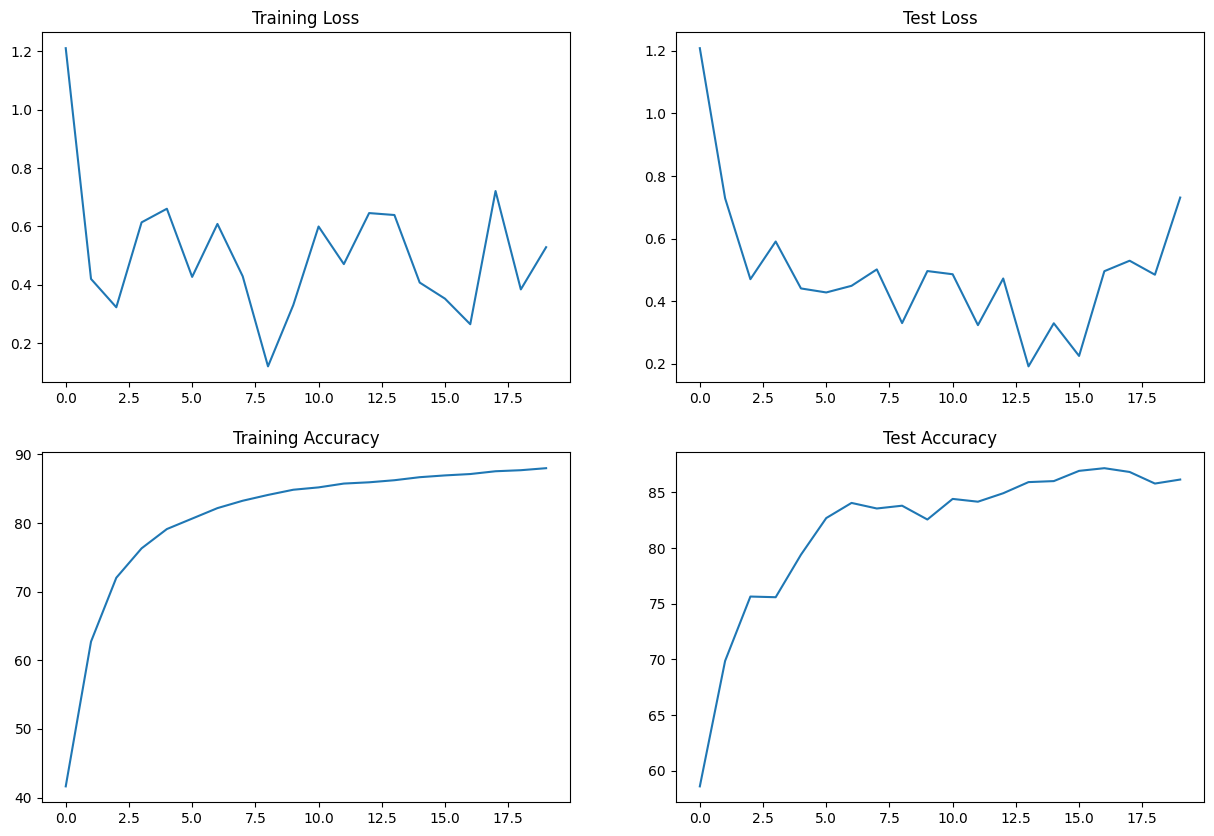

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

train_losses = torch.tensor(train_losses, device = 'cpu')
test_losses = torch.tensor(test_losses, device = 'cpu')

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [13]:
import cv2
incorrect_examples = []
predicted_classes = []
expected_classes = []
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, pred = outputs.max(1)
        idxs_mask = ((pred == targets) == False).nonzero()

        incorrect_examples.extend(inputs[idxs_mask])        
        predicted_classes.extend(pred[idxs_mask]) 
        expected_classes.extend(targets[idxs_mask])

        # print(len(incorrect_examples),len(predicted_classes),len(expected_classes))

In [14]:
len(incorrect_examples)

1385

C:\Users\Revathi.Balan\AppData\Local\Temp\ipykernel_3960\3199861485.py:18: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3575.)
  img = np.clip(img.cpu().T, 0, 1)


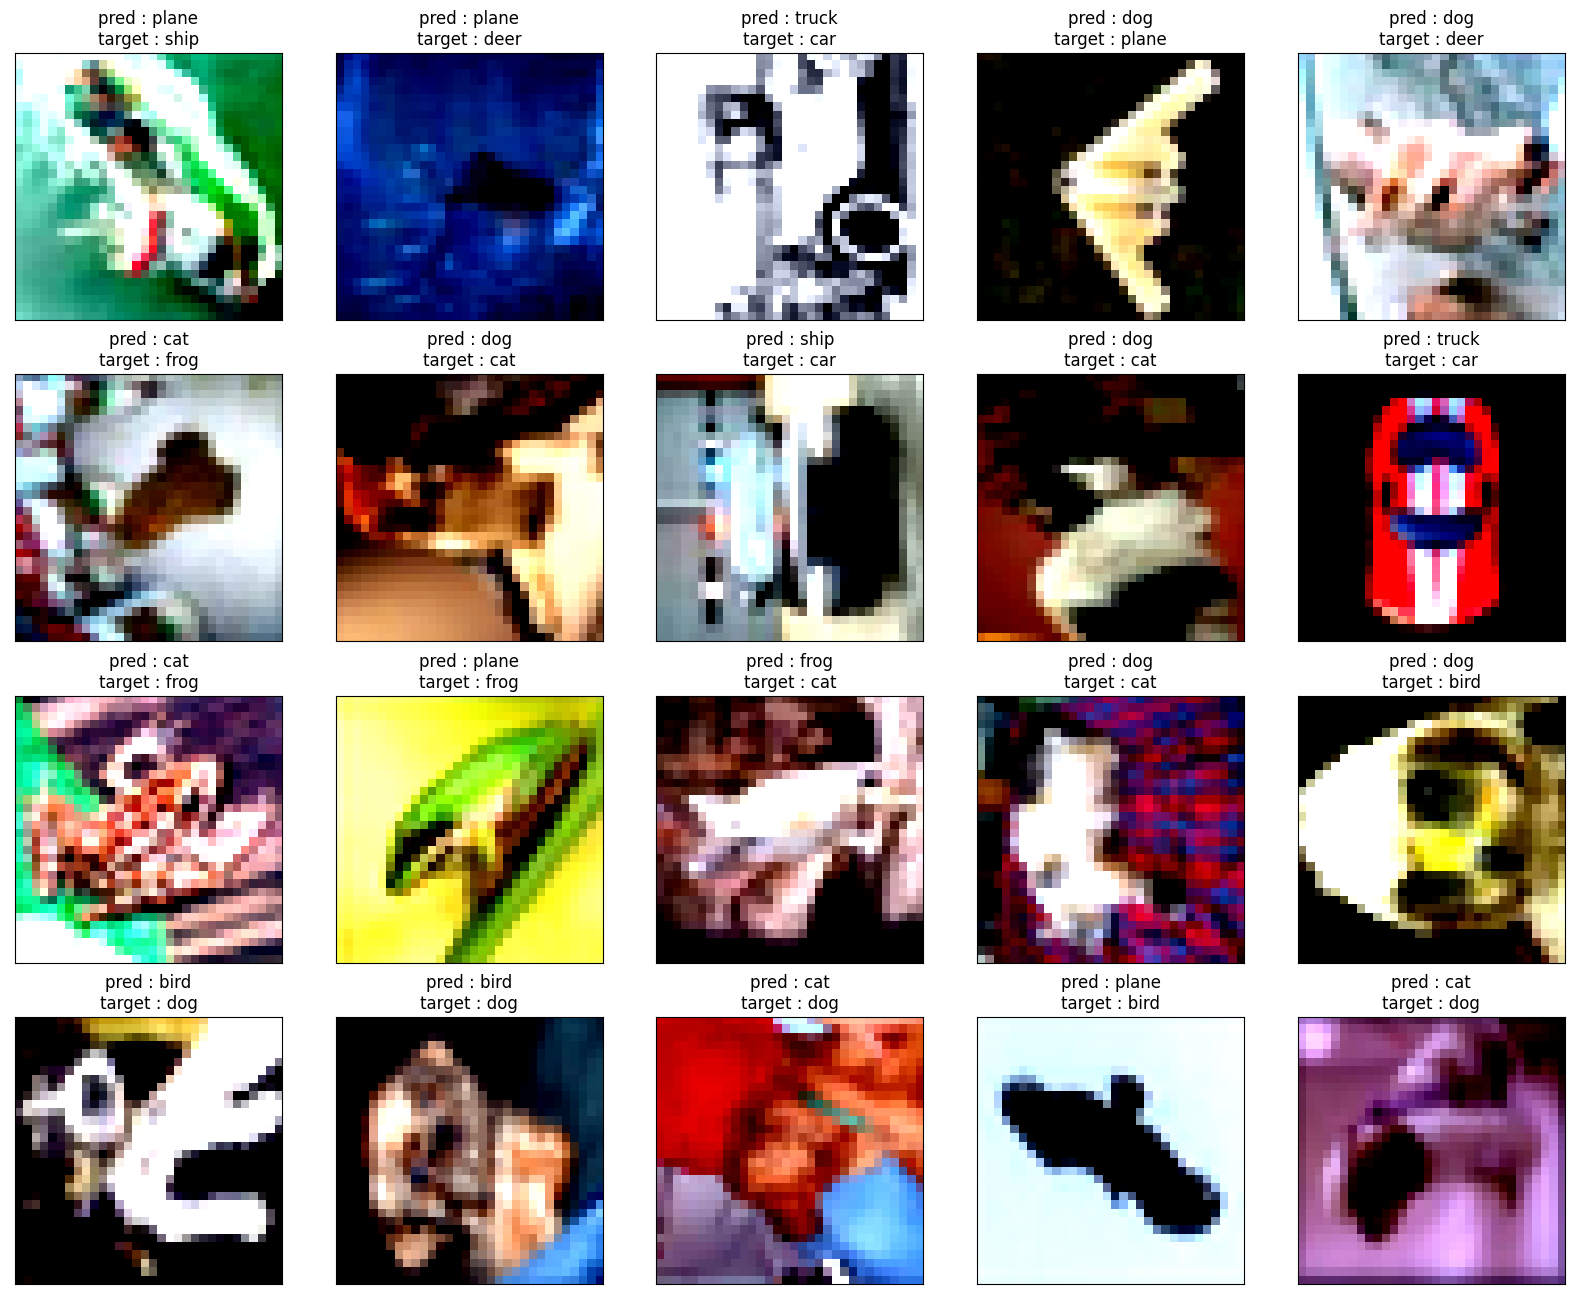

In [15]:
# !pip install grad-cam
import numpy as np
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50


target_layers = [net.module.layer4[-1]]

fig = plt.figure(figsize=(20, 16))

for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1,xticks=[],yticks=[])
    
    img = incorrect_examples[idx][0]
    img = img/2 + 0.5
    img = np.clip(img.cpu().T, 0, 1)
    plt.imshow(img)
    ax.set_title('pred : '+classes[predicted_classes[idx]]+'\n'+'target : '+classes[expected_classes[idx]])

    input_tensor = incorrect_examples[idx]

    # print(input_tensor.shape)


    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)

    targets = [ClassifierOutputTarget(predicted_classes[idx])]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam[0, :]
    # plt.imshow(grayscale_cam)
    # ax.set_title('pred : '+classes[predicted_classes[idx]]+'\n'+'target : '+classes[expected_classes[idx]])

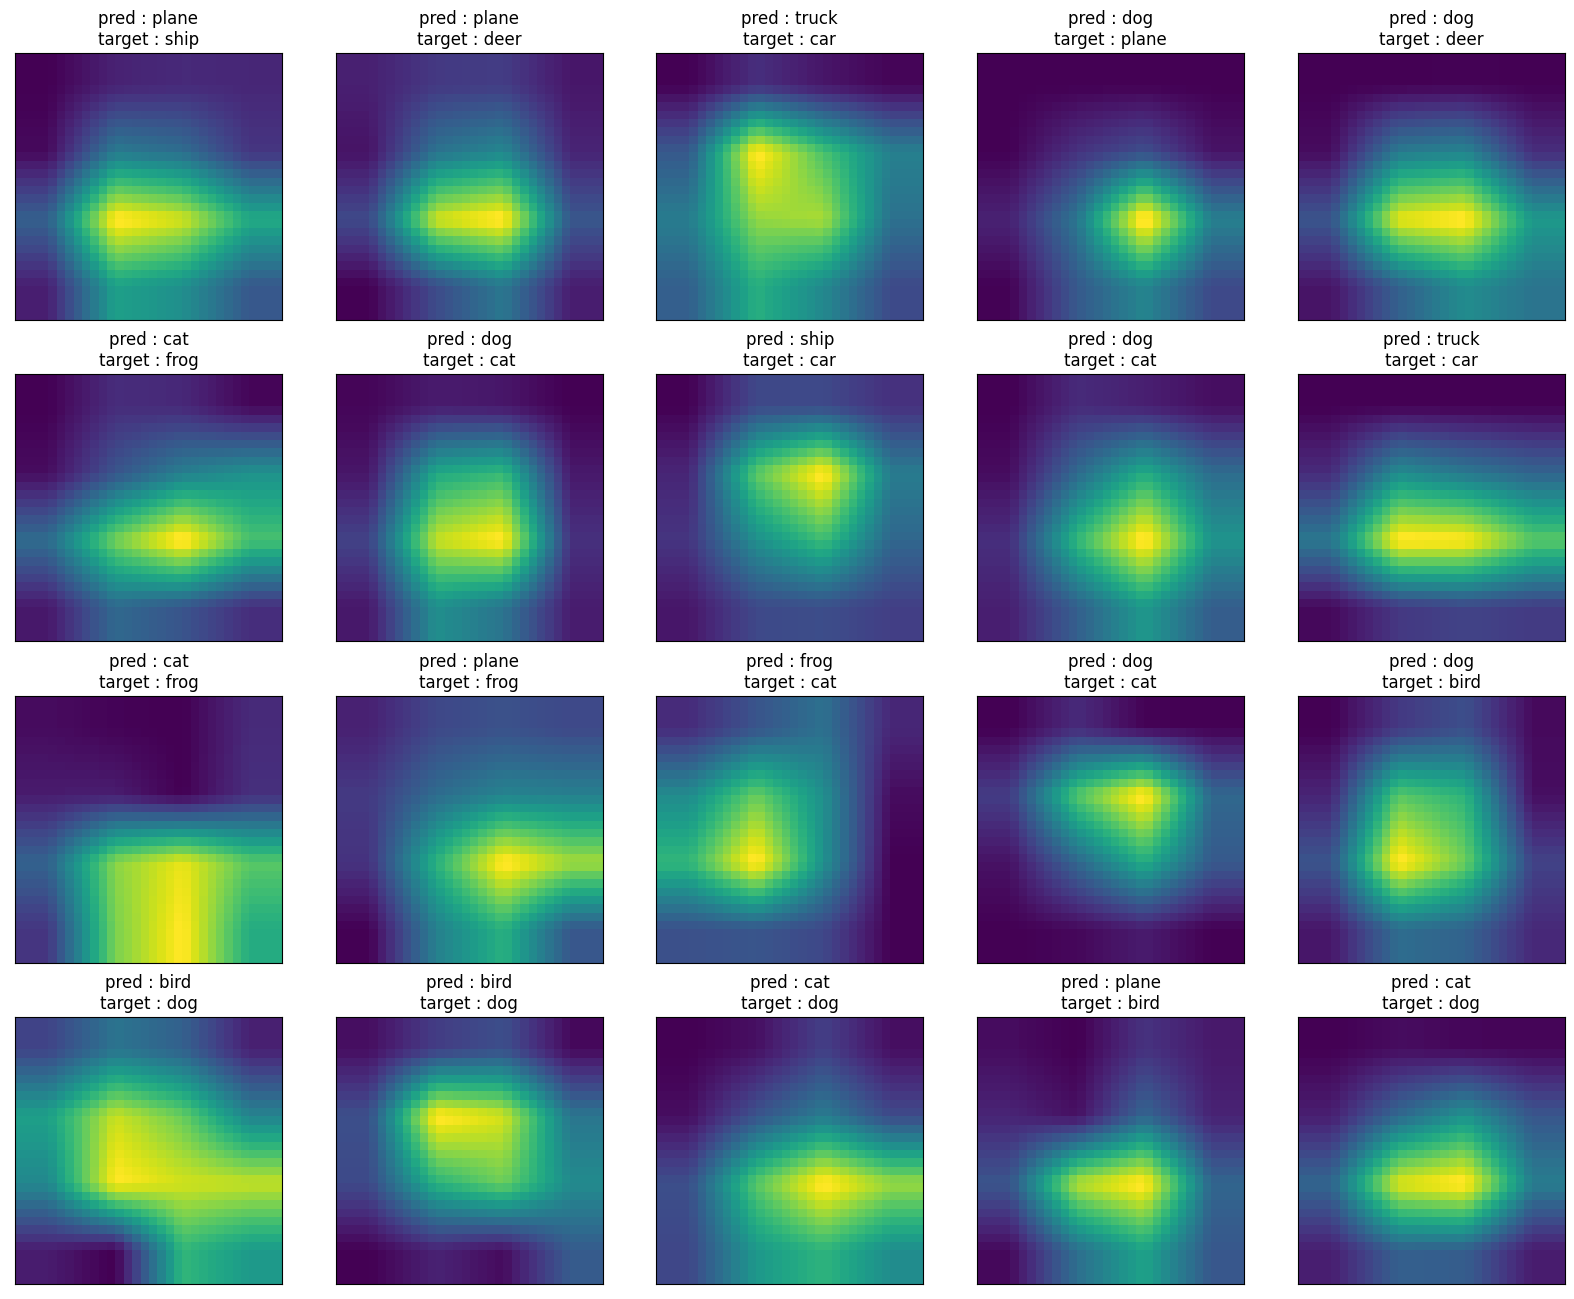

In [16]:
# !pip install grad-cam
import numpy as np
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50


target_layers = [net.module.layer4[-1]]

fig = plt.figure(figsize=(20, 16))

for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1,xticks=[],yticks=[])
    
    img = incorrect_examples[idx][0]
    img = img/2 + 0.5
    img = np.clip(img.cpu().T, 0, 1)
    # plt.imshow(img)
    # ax.set_title('pred : '+classes[predicted_classes[idx]]+'\n'+'target : '+classes[expected_classes[idx]])

    input_tensor = incorrect_examples[idx]

    # print(input_tensor.shape)


    # Construct the CAM object once, and then re-use it on many images:
    cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)

    targets = [ClassifierOutputTarget(predicted_classes[idx])]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    grayscale_cam = grayscale_cam[0, :]
    plt.imshow(grayscale_cam)
    ax.set_title('pred : '+classes[predicted_classes[idx]]+'\n'+'target : '+classes[expected_classes[idx]])